In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization,Dense,SeparableConv2D,MaxPooling2D,Activation,Flatten,Dropout

In [3]:
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 50
lr_find = True

classes = ['Non_Fire','Fire']

In [4]:
images = []
labels = []
for c in classes:
    try:
        for img in os.listdir('Image Dataset/'+c):
            img = cv2.imread('Image Dataset/'+c+'/'+img)
            img = cv2.resize(img,(128,128))
            images.append(img)
            labels.append([0,1][c=='Fire'])
    except:
        pass
    
images = np.array(images,dtype='float32')/255.


In [6]:
# just visualizing random images from the dataset created above 

ind = np.random.randint(0,len(images))
cv2.imshow(str(labels[ind]),images[ind])
cv2.waitKey(0)
cv2.destroyAllWindows()

ValueError: high <= 0

In [5]:
labels = np.array(labels)
labels = np_utils.to_categorical(labels,num_classes=2)

classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [7]:
d = {}
d[0] = classWeight[0]
d[1] = classWeight[1]
d

{0: 1.0, 1: 2.0441065}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, shuffle=True, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [10]:
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(16,(7,7),padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => POOL
model.add(SeparableConv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(len(classes)))
model.add(Activation("softmax"))

opt = SGD(learning_rate=INIT_LR, momentum=0.9,decay=INIT_LR / NUM_EPOCHS)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 128, 128, 16)      211       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 64, 64, 32)        688       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        1

In [12]:
print("[INFO] training network...")

H = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=d,
    verbose=1)

print("[INFO] serializing network to '{}'...".format('output/model'))
model.save('output/fire_detection.h5')

[INFO] training network...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
46/46 [==============================] - 11s 172ms/step - loss: 0.9779 - accuracy: 0.6464 - val_loss: 140.4940 - val_accuracy: 0.3027
Epoch 2/50
46/46 [==============================] - 9s 185ms/step - loss: 0.7281 - accuracy: 0.7185 - val_loss: 9.1485 - val_accuracy: 0.3407
Epoch 3/50
46/46 [==============================] - 9s 185ms/step - loss: 0.6424 - accuracy: 0.7423 - val_loss: 0.7409 - val_accuracy: 0.6374
Epoch 4/50
46/46 [==============================] - 9s 186ms/step - loss: 0.6535 - accuracy: 0.7539 - val_loss: 0.4738 - val_accuracy: 0.8042
Epoch 5/50
46/46 [==============================] - 9s 187ms/step - loss: 0.6531 - accuracy: 0.7628 - val_loss: 0.7218 - val_accuracy: 0.7512
Epoch 6/50
46/46 [==============================] - 9s 188ms/step - loss: 0.6167 - accuracy: 0.7648 - val_loss: 0.4988 - v

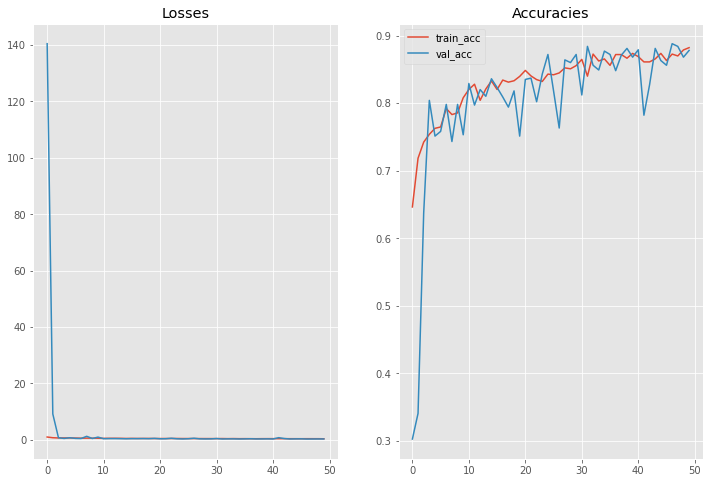

In [16]:
N = np.arange(0, NUM_EPOCHS)

plt.figure(figsize=(12,8))

plt.subplot(121)
plt.title("Losses")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")

plt.subplot(122)
plt.title("Accuracies")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")


plt.legend()
plt.savefig("output/training_plot.png")

In [3]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('output/fire_detection.h5')

[INFO] loading model...


In [4]:
for i in range(50):
    random_index = np.random.randint(0,len(X_test))
    org_img = X_test[random_index]*255
    img = org_img.copy()
    img = cv2.resize(img,(128,128))
    img = img.astype('float32')/256
    pred = model.predict(np.expand_dims(img,axis=0))[0]
    result = classes[np.argmax(pred)]
    org_img = cv2.resize(org_img,(500,500))
    cv2.putText(org_img, result, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 3)
    cv2.imwrite('output/testing/{}.png'.format(i),org_img)

NameError: name 'X_test' is not defined

In [1]:
#############me
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import keras.utils as image
#Load the saved model
model = tf.keras.models.load_model('output/fire_detection.h5')
#model = tf.keras.models.load_model('detection_model-ex-33--loss-4.97.h5')
video = cv2.VideoCapture(0)
while True:
        _, frame = video.read()
#Convert the captured frame into RGB
        im = Image.fromarray(frame, 'RGB')
#Resizing into 224x224 because we trained the model with this image size.
        im = im.resize((128,128))
        img_array = image.img_to_array(im)
        img_array = np.expand_dims(img_array, axis=0) / 255
        probabilities = model.predict(img_array)[0]
        #Calling the predict method on model to predict 'fire' on the image
        prediction = np.argmax(probabilities)
        #if prediction is 0, which means there is fire in the frame.
        if prediction == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                print(probabilities[prediction])
                prob = int(probabilities[prediction]*100)
                cv2.putText(frame, f'Fire: {prob}%', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        else:
            print("no fire")
        cv2.imshow("Capturing", frame)
        key=cv2.waitKey(1)
        if key == ord('q'):
            break
video.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 349ms/step
no fire
1/1 [==============================] - 0s 30ms/step
no fire
1/1 [==============================] - 0s 29ms/step
no fire
1/1 [==============================] - 0s 30ms/step
no fire
1/1 [==============================] - 0s 28ms/step
no fire
1/1 [==============================] - 0s 28ms/step
no fire
1/1 [==============================] - 0s 28ms/step
no fire
1/1 [==============================] - 0s 27ms/step
no fire
1/1 [==============================] - 0s 30ms/step
no fire
1/1 [==============================] - 0s 30ms/step
no fire
1/1 [==============================] - 0s 27ms/step
no fire
1/1 [==============================] - 0s 27ms/step
no fire
1/1 [==============================] - 0s 27ms/step
no fire
1/1 [==============================] - 0s 26ms/step
no fire
1/1 [==============================] - 0s 27ms/step
no fire
1/1 [==============================] - 0s 26ms/step
no fire
1/1 [==============================] - 

KeyboardInterrupt: 